In [14]:
!pip install pydicom

In [15]:
# Download efficientnets 
!pip install keras_efficientnets 

In [16]:
!pip install Keras-Applications

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import os
from google.colab import files
import matplotlib.image as mpimg
#import data

# tensoflow models
import tensorflow as tf
from keras import Sequential
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras_efficientnets import EfficientNetB0
from keras.utils import to_categorical
from keras_efficientnets import EfficientNetB0
from keras.models import load_model

In [18]:
#Its is my working directory, pleas changes as per you
%cd /content/drive/MyDrive/Self case study 2 

/content/drive/MyDrive/Self case study 2


**Enter a X-ray images ID to Predict lung disease on a image**

In [19]:
# image id shoud be without file extension
img_file = input("Input X-ray images ID to Predict lung disease:")

Input X-ray images ID to Predict lung disease:009bc039326338823ca3aa84381f17f1.dicom


**Befor predicting, please upload the image into floder** (file format is Dicom)

Please upload image into 'Test_files' directory

In [20]:
# we can load the image directly,It is very slow
#from google.colab import files
#uploaded = files.upload()

In [21]:
os.makedirs("Test_files", exist_ok=True) 

In [22]:
load_dir = '/content/drive/MyDrive/Self case study 2/'

In [23]:
# https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way
def read_xray(path, voi_lut = True, fix_monochrome = True):
  dicom = pydicom.read_file(path)
  # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
  if voi_lut:
    data = apply_voi_lut(dicom.pixel_array, dicom)
  else:
    data = dicom.pixel_array       
  # depending on this value, X-ray may look inverted - fix that:
  if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
    data = np.amax(data) - data
  data = data - np.min(data)
  data = data / np.max(data)
  data = (data * 255).astype(np.uint8) 
  return data
# Original from: https://www.kaggle.com/xhlulu/vinbigdata-process-and-resize-to-image
def resize(array, size, keep_ratio=False, resample=Image.LANCZOS):
    im = Image.fromarray(array)
    if keep_ratio:
        im.thumbnail((size, size), resample)
    else:
        im = im.resize((size, size), resample)
    return im
def img_conv(load_dir,img_file,size =512):
  dec_path = os.path.join(load_dir, "Test_files")
  xray = read_xray(os.path.join(dec_path,img_file))
  im = resize(xray, size, keep_ratio=True)
  os.makedirs(os.path.join(load_dir,'Test_png'), exist_ok=True)
  png_path = os.path.join(load_dir, "Test_png") 
  im.save(os.path.join(png_path,img_file.replace('dicom', 'png'))) 

In [24]:
IMG_WIDTH, IMG_HEIGHT =224,224
#Defining the model
model= Sequential()
base_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),classes=2)
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation=('relu'))) 
model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
model.add(Dropout(.2))
model.add(Dense(2,activation=('softmax'))) 
#Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 7, 7, 1280)        4049564   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               16056576  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                

In [25]:
def class_pred(img_file):
  img_conv(load_dir,img_file,size =512) 
  png_path = os.path.join(load_dir, "Test_png")
  test =[] 
  for f_name in os.listdir(png_path):
    test.append(f_name)
  #create new df 
  test_df = pd.DataFrame({'img_id':test}) 
  test_df= test_df[test_df['img_id']== img_file.replace('dicom', 'png')]
  model_path= '/content/drive/MyDrive/Self case study 2/models'
  model_name = 'best_model.h5'
  # load pretrained weights 
  wig_path = os.path.join(model_path,model_name) 
  pred_model= model.load_weights(wig_path)
  # create pipleline on test data
  test_datagen = ImageDataGenerator(rescale=1/255)
  test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,directory='/content/drive/MyDrive/Self case study 2/Test_png',
                                           x_col="img_id",
                                           y_col=None,seed=42,shuffle=False,
                                           target_size=(IMG_WIDTH, IMG_HEIGHT),
                                           class_mode=None)
  predict = model.predict_generator(test_generator,steps =1,verbose=1) 
  print("Probability that a person with Abnormal lung condition: {:5.2f}%".format(predict[0][0]*100))
  print("Probability that a person with Normal lung condition: {:5.2f}%".format(predict[0][1]*100)) 
  return predict 


In [26]:
class_pred(img_file)

Found 1 validated image filenames.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


1/1 [==============================] - 31s 31s/step
Probability that a person with Abnormal lung condition: 80.17%
Probability that a person with Normal lung condition: 19.83%


array([[0.8016621 , 0.19833793]], dtype=float32)

In [29]:
png_path = os.path.join(load_dir, "Test_png",img_file.replace('dicom', 'png'))
low_thr  = 0.08
high_thr = 0.80 
def filter_2cls(img_file, low_thr=low_thr, high_thr=high_thr):
  model_pred = class_pred(img_file)
  prob = model_pred[0][0]
  if prob<low_thr:
    print("Less chance of having any disease: {:5.2f}%".format(prob*100)) 
    img = mpimg.imread(png_path)
    plt.imshow(img,cmap="Spectral")
  elif low_thr<=prob<high_thr:
      ## More change of having any diesease
      print("change of having diesease: {:5.2f}%".format(prob*100)) 
      img = mpimg.imread(png_path)
      plt.imshow(img,cmap="Spectral")
  else:
      print("Good chance of having disease so believe in object detection model:{:5.2f}%".format(prob*100))
      %cd yolov5 
      !python detect.py --weights '/content/drive/MyDrive/Self case study 2/yolov5/runs/train/yolov5x_Xray11/weights/best.pt' --img 512 --conf 0.25 --source '/content/drive/MyDrive/Self case study 2/Test_png/{img_file.replace('dicom', 'png')}'
      img = mpimg.imread('/content/drive/MyDrive/Self case study 2/yolov5/runs/detect/exp3/009bc039326338823ca3aa84381f17f1.png')
      plt.imshow(img,cmap="Spectral")

Found 1 validated image filenames.
1/1 [==============================] - 0s 38ms/step
Probability that a person with Abnormal lung condition: 80.17%
Probability that a person with Normal lung condition: 19.83%
Good chance of having disease so believe in object detection model:80.17%
[Errno 2] No such file or directory: 'yolov5'
/content/drive/MyDrive/Self case study 2/yolov5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=512, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='/content/drive/MyDrive/Self case study 2/Test_png/009bc039326338823ca3aa84381f17f1.png', update=False, view_img=False, weights=['/content/drive/MyDrive/Self case study 2/yolov5/runs/train/yolov5x_Xray11/weights/best.pt'])
YOLOv5 🚀 2021-4-9 torch 1.8.1+cu101 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 224 layers, 7088971 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/Self case study 2/Test_png/009bc039326338823ca3aa84381f17f1.png: 512x448 1 Aortic enlargement, 1 Cardiomegaly, Done. (0.011s)
Results saved to runs/detect/exp3
Done. (0.032s)


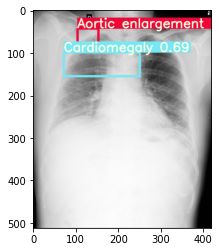

In [30]:
filter_2cls(img_file)